In [ ]:
!pip install shap pyDOE2
from IPython.core.display import display, HTML
import regex as re
import lightgbm
import pandas as pd
import shap
import sklearn
from copy import deepcopy

import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
!pip install seldonian-engine

shap.initjs()

Patch to match style consistency

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib.font_manager import FontProperties
from matplotlib.patches import PathPatch
from matplotlib.path import Path

plt.rcParams['figure.dpi'] = 300
import shap.plots._force_matplotlib

# PATCH draw_base_element
def patch_draw_base_element(base_value, ax):
    x, y = np.array([[base_value, base_value], [0.13, 0.25]])
    line = lines.Line2D(x, y, lw=2., color='#F2F2F2')
    line.set_clip_on(False)
    #ax.add_line(line)

    font0 = FontProperties()
    font = font0.copy()
    font.set_weight('bold')

    #text_out_val = plt.text(base_value, 0.25, f'{base_value:.2f}',
    #                        fontproperties=font,
    #                        fontsize=14,
    #                        horizontalalignment='center')
    #text_out_val.set_bbox(dict(facecolor='white', edgecolor='white'))

    #text_out_val = plt.text(base_value, 0.33, 'base value',
    #                        fontsize=12, alpha=0.5,
    #                        horizontalalignment='center')
    #text_out_val.set_bbox(dict(facecolor='white', edgecolor='white'))
shap.plots._force_matplotlib.draw_base_element = patch_draw_base_element
# ENDPATCH draw_base_element


# PATCH update_axis_limits
def patch_update_axis_limits(ax, total_pos, pos_features, total_neg,
                       neg_features, base_value, out_value):

    print("patched")
    ax.set_ylim(-0.5, 0.15)
    pos_padding = np.max([np.abs(total_pos) * 0.5,
                      np.abs(total_neg) * 0.5])  #0.8 # 0.6 #1.1
    neg_padding = np.max([np.abs(total_pos) * 0.8,
                      np.abs(total_neg) * 0.8])
    padding = np.max([np.abs(total_pos) * 0.8,
                      np.abs(total_neg) * 0.8])

    print(f"pos {pos_padding}, neg {neg_padding}")

    if len(pos_features) > 0:
        min_x = min(np.min(pos_features[:, 0].astype(float)), base_value) - neg_padding
    else:
        min_x = out_value - padding
    if len(neg_features) > 0:
        max_x = max(np.max(neg_features[:, 0].astype(float)), base_value) + pos_padding
    else:
        max_x = out_value + padding



    ax.set_xlim(0.0, 0.4)

    plt.tick_params(top=True, bottom=False, left=False, right=False, labelleft=False,
                    labeltop=True, labelbottom=False)
    plt.locator_params(axis='x', nbins=12)

    for key, spine in zip(plt.gca().spines.keys(), plt.gca().spines.values()):
        if key != 'top':
            spine.set_visible(False)
shap.plots._force_matplotlib.update_axis_limits = patch_update_axis_limits
# ENDPATCH update_axis_limits


def patch_draw_bars(out_value, features, feature_type, width_separators, width_bar):
    """Draw the bars and separators."""
    rectangle_list = []
    separator_list = []

    pre_val = out_value
    for index, features in zip(range(len(features)), features):
        if feature_type == 'positive':
            left_bound = float(features[0])
            right_bound = pre_val
            pre_val = left_bound

            separator_indent = np.abs(width_separators)
            separator_pos = left_bound
            colors = ['#228B22', '#ECFFDC']
        else:
            left_bound = pre_val
            right_bound = float(features[0])
            pre_val = right_bound

            separator_indent = - np.abs(width_separators)
            separator_pos = right_bound
            colors = ['#800080', '#E6E6FA']

        # Create rectangle
        if index == 0:
            if feature_type == 'positive':
                points_rectangle = [[left_bound, 0],
                                    [right_bound, 0],
                                    [right_bound, width_bar],
                                    [left_bound, width_bar],
                                    [left_bound + separator_indent, (width_bar / 2)]
                                    ]
            else:
                points_rectangle = [[right_bound, 0],
                                    [left_bound, 0],
                                    [left_bound, width_bar],
                                    [right_bound, width_bar],
                                    [right_bound + separator_indent, (width_bar / 2)]
                                    ]

        else:
            points_rectangle = [[left_bound, 0],
                                [right_bound, 0],
                                [right_bound + separator_indent * 0.90, (width_bar / 2)],
                                [right_bound, width_bar],
                                [left_bound, width_bar],
                                [left_bound + separator_indent * 0.90, (width_bar / 2)]]

        line = plt.Polygon(points_rectangle, closed=True, fill=True,
                           facecolor=colors[0], linewidth=0)
        rectangle_list += [line]

        # Create separator
        points_separator = [[separator_pos, 0],
                            [separator_pos + separator_indent, (width_bar / 2)],
                            [separator_pos, width_bar]]

        line = plt.Polygon(points_separator, closed=None, fill=None,
                           edgecolor=colors[1], lw=3)
        separator_list += [line]

    return rectangle_list, separator_list
shap.plots._force_matplotlib.draw_bars = patch_draw_bars


def patch_draw_labels(fig, ax, out_value, features, feature_type, offset_text, total_effect=0, min_perc=0.05, text_rotation=0):
    start_text = out_value
    pre_val = out_value

    # Define variables specific to positive and negative effect features
    if feature_type == 'positive':
        colors = ['#228B22', '#ECFFDC']
        alignment = 'right'
        sign = 1
    else:
        colors = ['#800080', '#E6E6FA']
        alignment = 'left'
        sign = -1

    # Draw initial line
    if feature_type == 'positive':
        x, y = np.array([[pre_val, pre_val], [0, -0.18]])
        line = lines.Line2D(x, y, lw=1., alpha=0.5, color=colors[0])
        line.set_clip_on(False)
        ax.add_line(line)
        start_text = pre_val

    box_end = out_value
    val = out_value
    for feature in features:
        # Exclude all labels that do not contribute at least 10% to the total
        feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)
        if feature_contribution < min_perc:
            break

        # Compute value for current feature
        val = float(feature[0])

        # Draw labels.
        if feature[1] == "":
            text = feature[2]
        else:
            text = feature[2] + ' = ' + feature[1]

        if text_rotation != 0:
            va_alignment = 'top'
        else:
            va_alignment = 'baseline'

        text_out_val = plt.text(start_text - sign * offset_text,
                                -0.15, text,
                                fontsize=12, color=colors[0],
                                horizontalalignment=alignment,
                                va=va_alignment,
                                rotation=text_rotation)
        text_out_val.set_bbox(dict(facecolor='none', edgecolor='none'))

        # We need to draw the plot to be able to get the size of the
        # text box
        fig.canvas.draw()
        box_size = text_out_val.get_bbox_patch().get_extents()\
                               .transformed(ax.transData.inverted())
        if feature_type == 'positive':
            box_end_ = box_size.get_points()[0][0]
        else:
            box_end_ = box_size.get_points()[1][0]

        # Create end line
        if (sign * box_end_) > (sign * val):
            x, y = np.array([[val, val], [0, -0.18]])
            line = lines.Line2D(x, y, lw=1., alpha=0.5, color=colors[0])
            line.set_clip_on(False)
            ax.add_line(line)
            start_text = val
            box_end = val

        else:
            box_end = box_end_ - sign * offset_text
            x, y = np.array([[val, box_end, box_end],
                             [0, -0.08, -0.18]])
            line = lines.Line2D(x, y, lw=1., alpha=0.5, color=colors[0])
            line.set_clip_on(False)
            ax.add_line(line)
            start_text = box_end

        # Update previous value
        pre_val = float(feature[0])


    # Create line for labels
    extent_shading = [out_value, box_end, 0, -0.31]
    path = [[out_value, 0], [pre_val, 0], [box_end, -0.08],
            [box_end, -0.2], [out_value, -0.2],
            [out_value, 0]]

    path = Path(path)
    patch = PathPatch(path, facecolor='none', edgecolor='none')
    ax.add_patch(patch)

    # Extend axis if needed
    lower_lim, upper_lim = ax.get_xlim()
    if (box_end < lower_lim):
        ax.set_xlim(box_end, upper_lim)

    if (box_end > upper_lim):
        ax.set_xlim(lower_lim, box_end)

    # Create shading
    if feature_type == 'positive':
        colors = np.array([(34, 139, 34), (255, 255, 255)]) / 255.
    else:
        colors = np.array([(128, 0, 128), (255, 255, 255)]) / 255.

    cm = matplotlib.colors.LinearSegmentedColormap.from_list('cm', colors)

    _, Z2 = np.meshgrid(np.linspace(0, 10), np.linspace(-10, 10))
    im = plt.imshow(Z2, interpolation='quadric', cmap=cm,
                    vmax=0.01, alpha=0.3,
                    origin='lower', extent=extent_shading,
                    clip_path=patch, clip_on=True, aspect='auto')
    im.set_clip_path(patch)

    return fig, ax
shap.plots._force_matplotlib.draw_labels = patch_draw_labels

def patch_draw_higher_lower_element(out_value, offset_text):
    plt.text(out_value - offset_text, 0.405, 'higher',
             fontsize=13, color='#228B22',
             horizontalalignment='right')

    plt.text(out_value + offset_text, 0.405, 'lower',
             fontsize=13, color='#800080',
             horizontalalignment='left')

    plt.text(out_value, 0.4, r'$\leftarrow$',
             fontsize=13, color='#800080',
             horizontalalignment='center')

    plt.text(out_value, 0.425, r'$\rightarrow$',
             fontsize=13, color='#228B22',
             horizontalalignment='center')
shap.plots._force_matplotlib.draw_higher_lower_element = patch_draw_higher_lower_element

def _update_title_position_patch(self, renderer):
    """
    Update the title position based on the bounding box enclosing
    all the ticklabels and x-axis spine and xlabel...
    """
    if self._autotitlepos is not None and not self._autotitlepos:
       return

    titles = (self.title, self._left_title, self._right_title)

    for title in titles:
        x, _ = title.get_position()
        # need to start again in case of window resizing
        title.set_position((x, 1.0))
        # need to check all our twins too...
        axs = self._twinned_axes.get_siblings(self)
        # and all the children
        for ax in self.child_axes:
            if ax is not None:
                locator = ax.get_axes_locator()
                if locator:
                    pos = locator(self, renderer)
                    ax.apply_aspect(pos)
                else:
                    ax.apply_aspect()
                axs = axs + [ax]
        top = -np.inf
        for ax in axs:
            if (ax.xaxis.get_ticks_position() in ['top', 'unknown']
                    or ax.xaxis.get_label_position() == 'top'):
                bb = ax.xaxis.get_tightbbox(renderer)
            else:
                bb = ax.get_window_extent(renderer)
            if bb is not None:
                top = max(top, bb.ymax)
        if top < 0:
            # the top of Axes is not even on the figure, so don't try and
            # automatically place it.
           return
        if title.get_window_extent(renderer).ymin < top:
            _, y = self.transAxes.inverted().transform((0, top))
            title.set_position((x, y))
            # empirically, this doesn't always get the min to top,
            # so we need to adjust again.
            if title.get_window_extent(renderer).ymin < top:
                _, y = self.transAxes.inverted().transform(
                    (0., 2 * top - title.get_window_extent(renderer).ymin))
                title.set_position((x, y))

    ymax = max(title.get_position()[1] for title in titles)
    for title in titles:
        # now line up all the titles at the highest baseline.
        x, _ = title.get_position()
        title.set_position((x, ymax))
matplotlib.axes._base._AxesBase._update_title_position = _update_title_position_patch

Set up tutorial examples

Start by training the "should you bring an umbrella?" model

In [ ]:
preX = pd.read_csv("Umbrella.csv")
preX = preX.sample(frac=1)
X_display = preX.iloc[:,:-1]
y_display = preX.iloc[:,-1]

PRECIPITATION = {
    "none": 0,
    "drizzle": 1,
    "rain": 2,
    "snow": 3,
    "sleet": 4,
    "hail": 5
}

y = y_display
X = X_display
X = X.replace({"Precipitation":PRECIPITATION})

X_train = X.iloc[:300]
y_train = y.iloc[:300]

X_test = X.iloc[300:]
y_test = y.iloc[300:]

d_train = lightgbm.Dataset(X_train, label=y_train)
d_test = lightgbm.Dataset(X_test, label=y_test)

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "keep_training_booster": True
}

#model = lgb.train(params, d_train, 10000, valid_sets=[d_test]) #early_stopping_rounds=50, verbose_eval=1000
model = lightgbm.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

/tmp/ipython-input-6-1121137351.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({"Precipitation":PRECIPITATION})


LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

Find the location of one of the two tutorial examples

In [ ]:
print(X.loc[(X['Precipitation'] == 5) & (X['Temperature'] == 23) & (X['Wind(mph)'] == 10)])
print(X.loc[(X['Precipitation'] == 0) & (X['Temperature'] == 70) & (X['Wind(mph)'] == 30)])
theloc = X.index.get_loc(330)

     Precipitation  Temperature  Wind(mph)
330              5           23         10
    Precipitation  Temperature  Wind(mph)
96              0           70         30


Generate a tutorial explanation

patched
pos 0.03999999999999998, neg 0.06399999999999997


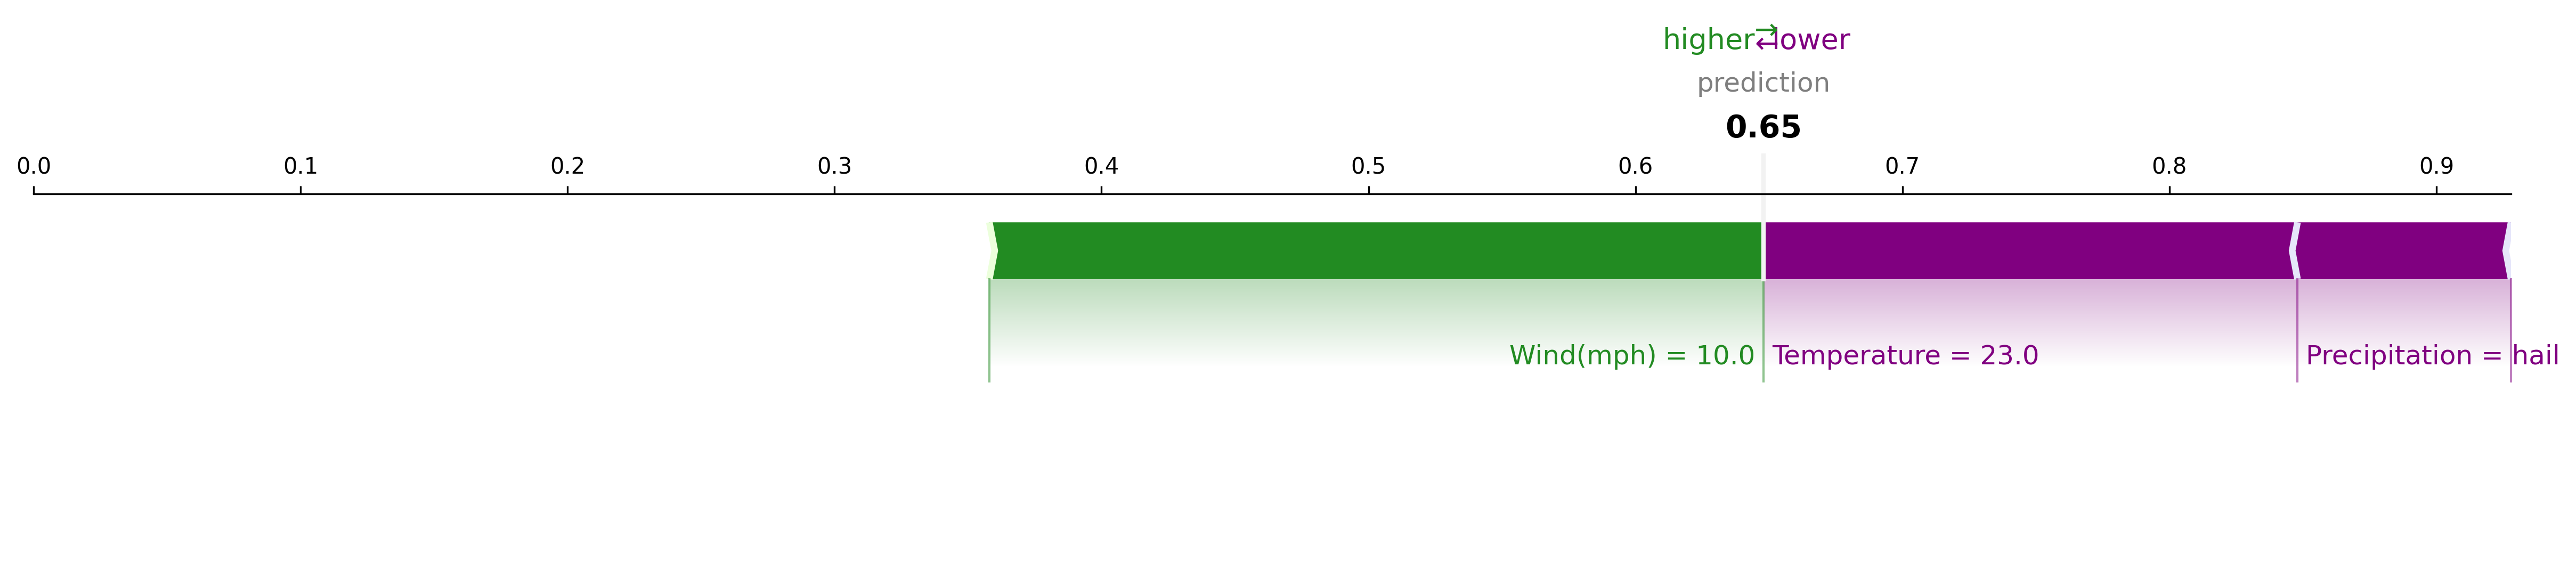

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
#shap_values = explainer(X)
shap.plots.force(0.638, shap_values = np.array([-0.08, -0.2, 0.29]), features = X_display.iloc[theloc,:], out_names="prediction", contribution_threshold=0.000001, matplotlib=True, figsize=(20,3), show=True)

#Loan Instances

Edit and prepare dataset

In [ ]:
# load dataset
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

EDUCATION_NUM = {
    16.0: "Doctorate",
    15.0: "Prof. School",
    14.0: "Masters",
    13.0: "Bachelors",
    12.0: "Some College",
    11.0: "Associate", #Assoc-acdm
    10.0: "Vocational", #Assoc-voc
    9.0: "HS grad",
    8.0: "12th",
    7.0: "11th",
    6.0: "10th",
    5.0: "9th",
    4.0: "7th-8th",
    3.0: "5th-6th",
    2.0: "1st-4th",
    1.0: "Preschool"
}

OCCUPATION_NUM = {
    "Tech-support": "Tech Support",
    "Craft-repair": "Craft/Repair",
    "Other-service": "Other Service",
    "Sales": "Sales",
    "Exec-managerial": "Exec. Managerial",
    "Prof-specialty": "Prof. Specialty",
    "Handlers-cleaners": "Handler/Cleaner",
    "Machine-op-inspct": "Machine Op. Inspector",
    "Adm-clerical": "Admin. Clerical",
    "Farming-fishing": "Farming/Fishing",
    "Transport-moving": "Transport/Moving",
    "Priv-house-serv": "Private House Service",
    "Protective-serv": "Protective Service",
    "Armed-Forces": "Armed Forces"

}
X_display = X_display.replace({"Education-Num":EDUCATION_NUM})
X_display = X_display.replace({"Occupation":OCCUPATION_NUM})
X = X.rename(columns={"Education-Num": "Education"})
X_display = X_display.rename(columns={"Education-Num": "Education"})#, "Hours per week": "Hours worked per week"})

X = X.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)
X_display = X_display.drop(['Capital Loss', 'Capital Gain', 'Race', 'Relationship', 'Country', 'Workclass', 'Marital Status'], axis=1)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

Train the model

In [ ]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    'objective':'multi:softprob',
    "boost_from_average": True
}

params_xgb={
    'base_score':0.5,
    'learning_rate':0.05,
    'max_depth':5,
    'min_child_weight':100,
    'n_estimators':200,
    'num_class': 2,
    'nthread':-1,
    'objective':'multi:softprob',
    'seed':2018,
    'eval_metric':'auc'
}

model = lgb.LGBMClassifier(max_bin= 512,
    learning_rate= 0.05,
    boosting_type= "gbdt",
    objective= "binary",
    metric= "binary_logloss",
    num_leaves= 10,
    verbose= -1,
    min_data= 100,
    boost_from_average= True)
model.fit(X_train, y_train)

LGBMClassifier(boost_from_average=True, learning_rate=0.05, max_bin=512,
               metric='binary_logloss', min_data=100, num_leaves=10,
               objective='binary', verbose=-1)

In [ ]:
X_test

,Age,Education,Occupation,Sex,Hours per week
18329,39.0,10.0,4,0,40.0
997,48.0,13.0,4,1,58.0
13225,22.0,10.0,8,1,35.0
6837,23.0,8.0,4,1,40.0
29132,50.0,13.0,12,1,8.0
...,...,...,...,...,...
23959,19.0,10.0,1,0,20.0
30638,25.0,9.0,12,1,60.0
6640,18.0,10.0,0,0,6.0
19186,23.0,4.0,7,0,40.0


In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability of loan granted
new_y_pred = (y_pred_proba >= 0.5).astype(int)

female_mask = X_test['Sex'] == 0
percent_female_loans = new_y_pred[female_mask].mean() * 100
print(f"Predicted % of females who get loans: {percent_female_loans:.2f}%")

male_mask = X_test['Sex'] == 1
percent_male_loans = new_y_pred[male_mask].mean() * 100
print(f"Predicted % of males who get loans: {percent_male_loans:.2f}%")

older_mask = X_test['Age'] >= 37
percent_older_loans = new_y_pred[older_mask].mean() * 100
print(f"Predicted % of people age >= 37 who get loans: {percent_older_loans:.2f}%")

younger_mask = X_test['Age'] < 37
percent_younger_loans = new_y_pred[younger_mask].mean() * 100
print(f"Predicted % of people age < 37 who get loans: {percent_younger_loans:.2f}%")

Predicted % of females who get loans: 1.43%
Predicted % of males who get loans: 24.08%
Predicted % of people age >= 37 who get loans: 27.17%
Predicted % of people age < 37 who get loans: 5.35%


Our 7 loan application instances

In [ ]:
#val = 610 # Woman Side-by-side
#val = 11116 # Man Side-by-side
#val = 32353 # Man 3
#val = 217 # Man 2
#val = 15040 # Man 1
#val = 32429 # Woman 3
val = 32556 # Woman 2
#val = 91#91 # Woman 1

theloc = val

Generate SHAP Explanation

In [ ]:
explainer = shap.Explainer(model, X, model_output="probability")
shap_values = explainer(X)

In [ ]:
#shap_values_standin0 = pd.Series({'Age': 0.0307, 'Education': -0.0287, 'Occupation': -0.0026, 'Sex': -0.1075, 'Hours per week': -0.0351}) # Woman 1
shap_values_standin0 = pd.Series({'Age': -0.14, 'Education': 0.0416, 'Occupation':  0.0216, 'Sex': -0.0355, 'Hours per week':  -0.0692}) # Woman 2
#shap_values_standin0 = pd.Series({'Age': 0.1209, 'Education': 0.3008, 'Occupation': 0.0317, 'Sex': -0.0766, 'Hours per week':  0.0115}) # Woman 3
#shap_values_standin0 = pd.Series({'Age': -0.2119, 'Education': 0.0011, 'Occupation': 0.0171,'Sex': 0.0096, 'Hours per week':  -0.0149}) # Man 1
#shap_values_standin0 = pd.Series({'Age': 0.0565, 'Education': 0.1427, 'Occupation': 0.0507, 'Sex': 0.0854, 'Hours per week':  0.0756}) # Man 2
#shap_values_standin0 = pd.Series({'Age': -0.0012, 'Education': -0.189, 'Occupation': 0.0022, 'Sex': 0.0448, 'Hours per week':  0.0256}) # Man 3
#shap_values_standin0 = pd.Series({'Age': 0.0774, 'Education': 0.1962, 'Occupation': 0.0318, 'Sex': 0.106, 'Hours per week':  0.0741}) # Man Fair
#shap_values_standin0 = pd.Series({'Age': 0.0668, 'Education': 0.1619, 'Occupation': 0.0297,'Sex': -0.1366, 'Hours per week':  0.0318}) # Woman Fair

shap.plots.force(0.259, shap_values = np.array(shap_values_standin0), features = X_display.iloc[theloc,:], out_names="prediction", contribution_threshold=0.000001, matplotlib=True, figsize=(20,3), show=True)


#Fair Model

In [ ]:
import os
import shutil
!git clone https://github.com/seldonian-toolkit/Experiments.git
# Rename the 'Experiments' directory to 'old_Experiments'
os.rename('Experiments', 'old_Experiments')

# Move the 'experiments' directory from inside 'old_Experiments' to the current directory
shutil.move('old_Experiments/experiments', 'experiments')

Cloning into 'Experiments'...
remote: Enumerating objects: 3528, done.
remote: Counting objects: 100% (640/640), done.
remote: Compressing objects: 100% (308/308), done.
remote: Total 3528 (delta 487), reused 458 (delta 332), pack-reused 2888 (from 1)
Receiving objects: 100% (3528/3528), 15.19 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (2690/2690), done.


'experiments'

Train the fair model using seldonian

In [ ]:
import os
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from seldonian.utils.io_utils import save_json

import matplotlib.pyplot as plt
%matplotlib inline


# Helpful reference: https://machinelearningmastery.com/imbalanced-classification-of-good-and-bad-credit/

# Point to german.csv file on your filesystem
f_orig = "/Users/ahoag/beri/code/datasets/german_credit/german.csv"

def make_seldonian_dataset(X_train_temp,y_train_temp):
    """ load the dataset into features and label arrays.
    One-hot encode categorical features,
    scale numerical features to have unit variance and 0 mean
    and then encode label column to have binary output:
    0: good credit and 1: bad credit.
    Finally, save resulting dataframe to a CSV file
    and make metadata JSON file

    :param input_path: The path to the original dataset in CSV format
    :type input_path: str

    :param output_path_data: The filename for saving the reformated dataset file
    :type output_path_data: str

    :param output_path_metadata: The filename for saving the reformated metadata file
    :type output_path_metadata: str
    """


    # Need to make male and female columns from personal status column and then remove the personal_status column
    #female_mask = np.logical_or(X['Sex']==0)
    #X_fair.loc[female_mask,'Sex'] = "F"
    #X_fair.loc[~female_mask,'Sex'] = "M"

    # select categorical features and numerical features
    #cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    #num_ix = X.select_dtypes(include=['int64', 'float64']).columns

    X_fair = deepcopy(X_train_temp)
    y_fair = deepcopy(y_train_temp)
    X_fair['Young'] = np.where(X_fair['Age'] < 37.00, 1, 0)

    X_fair.drop(['Age'], axis=1)

    # Ensure categorical columns are of type object (or category)
    X_fair['Education'] = X_fair['Education'].astype('float64')
    X_fair['Occupation'] = X_fair['Occupation'].astype('float64')

    X_fair['Sex'] = X_fair['Sex'].astype('object')

    # Ensure categorical columns are of type object (or category)
    X_fair['Young'] = X_fair['Young'].astype('object')
    X_fair['Hours per week'] = X_fair['Hours per week'].astype('float64')


    # select categorical features and numerical features
    cat_ix = X_fair.select_dtypes(include=['object', 'bool']).columns
    num_ix = X_fair.select_dtypes(include=['int64', 'float64']).columns

    # one hot encode cat features only, scale numerical features using standard scaler
    #ct = ColumnTransformer([('c',OneHotEncoder(drop=None),cat_ix), ('n',StandardScaler(),num_ix)])
    ct = ColumnTransformer([('c',OneHotEncoder(drop=None),cat_ix), ('n','passthrough',num_ix)])
    # Apply transformation
    X_fair = ct.fit_transform(X_fair)#.toarray()


    # label encode the target variable to have the classes 0 and 1
    # 0 is good credit, 1 is bad credit
    y_fair = LabelEncoder().fit_transform(y_fair)

    # Get names after one-hot encoding
    output_columns = ct.get_feature_names_out(ct.feature_names_in_)

    # Make an output dataframe to save from X and y
    outdf = pd.DataFrame(X_fair,columns=output_columns)


    # Change name of the two one-hot encoded sex columns to M and F
    outdf.rename(columns={'c__Sex_0':'F','c__Sex_1':'M'},inplace=True)
    outdf.rename(columns={'c__Young_0':'O','c__Young_1':'Y'},inplace=True)
    outdf.rename(columns={'n__Occupation':'Occupation', 'n__Education': 'Education', 'n__Hours per week': 'Hours per week'},inplace=True)
    print(outdf)
    # Add label column into final dataframe
    outdf['Approve Loan'] = y_fair
    #outdf['Gender'] = np.where(outdf['M'] == 1.0, 1.0, 0.0)
    #outdf['Gender'] = outdf['Gender'].astype('object')
    #print(outdf)

    # Save final dataframe

    outdf.to_csv("loan_numeric_forseldonian.csv",index=False,header=False)
    print(f"Saved data file to: loan_numeric_forseldonian.csv")

    # Save metadata json file
    metadata_dict = {
        "regime":"supervised_learning",
        "sub_regime":"classification",
        "all_col_names":list(outdf.columns),
        "label_col_names":"Approve Loan",
        "sensitive_col_names":["F","M","O","Y"]
    }

    with open("metadata_loan.json",'w') as outfile:
        json.dump(metadata_dict,outfile,indent=2)
    print(f"Saved metadata file to: metadata_loan.json")

    return outdf

X_fair_train = make_seldonian_dataset(X_train,y_train)


X_fair_test = make_seldonian_dataset(X_test,y_test)

         F    M    O    Y  Education  Occupation  Hours per week
0      1.0  0.0  1.0  0.0       10.0         6.0            40.0
1      0.0  1.0  1.0  0.0       14.0        12.0            50.0
2      0.0  1.0  0.0  1.0       11.0         3.0            40.0
3      0.0  1.0  0.0  1.0       10.0        12.0            24.0
4      0.0  1.0  1.0  0.0       13.0         1.0            38.0
...    ...  ...  ...  ...        ...         ...             ...
26043  0.0  1.0  0.0  1.0        9.0        12.0            40.0
26044  0.0  1.0  1.0  0.0        9.0         7.0            40.0
26045  0.0  1.0  0.0  1.0        5.0         3.0            40.0
26046  0.0  1.0  1.0  0.0       16.0        10.0            55.0
26047  1.0  0.0  1.0  0.0       10.0        13.0            40.0

[26048 rows x 7 columns]
Saved data file to: loan_numeric_forseldonian.csv
Saved metadata file to: metadata_loan.json
        F    M    O    Y  Education  Occupation  Hours per week
0     1.0  0.0  1.0  0.0       10.0  

In [ ]:
import os
import autograd.numpy as np

from seldonian.dataset import DataSetLoader
from seldonian.parse_tree.parse_tree import make_parse_trees_from_constraints
from seldonian.utils.io_utils import save_pickle
from seldonian.spec import SupervisedSpec
from seldonian.models import objectives
from experiments.perf_eval_funcs import probabilistic_accuracy

from seldonian.models.trees.skrandomforest_model import SeldonianRandomForest, probs2theta

def initial_solution_fn(model,features,labels):
    probs = model.fit(features,labels)
    return probs2theta(probs)

# 1. Dataset
data_pth = 'loan_numeric_forseldonian.csv'
metadata_pth = 'metadata_loan.json'
regime='supervised_learning'
sub_regime='classification'

loader = DataSetLoader(
    regime=regime)
dataset = loader.load_supervised_dataset(
    filename=data_pth,
    metadata_filename=metadata_pth,
    file_type='csv')


sensitive_col_names = dataset.meta.sensitive_col_names
frac_data_in_safety = 0.6

# 2. Specify behavioral constraints
deltas = [0.05, 0.05] # confidence levels
for constraint_name in ["disparate_impact",
    "demographic_parity","equalized_odds",
    "equal_opportunity","predictive_equality"]:
    # Define behavioral constraints
    if constraint_name == 'disparate_impact':
        epsilon = 0.9
        constraint_strs = [f'min(min((PR | [M])/(PR | [F]),(PR | [F])/(PR | [M])), min((PR | [Y])/(PR | [O]),(PR | [O])/(PR | [Y]))) >= {epsilon}']
    elif constraint_name == 'demographic_parity':
        epsilon = 0.1
        constraint_strs = [f'abs((PR | [O]) - (PR | [Y])) <= {epsilon}',f'abs((PR | [M]) - (PR | [F])) <= {epsilon}']
    elif constraint_name == 'equalized_odds':
        epsilon = 0.15
        constraint_strs = [f'abs((FNR | [M]) - (FNR | [F])) + abs((FPR | [M]) - (FPR | [F])) <= {epsilon}', f'abs((FNR | [O]) - (FNR | [Y])) + abs((FPR | [Y]) - (FPR | [O])) <= {epsilon}']
    elif constraint_name == 'equal_opportunity':
        epsilon = 0.1
        constraint_strs = [f'abs((FNR | [M]) - (FNR | [F])) <= {epsilon}', f'abs((FNR | [O]) - (FNR | [Y])) <= {epsilon}']
    elif constraint_name == 'predictive_equality':
        epsilon = 0.1
        constraint_strs = [f'abs((FPR | [M]) - (FPR | [F])) <= {epsilon}', f'abs((FPR | [O]) - (FPR | [Y])) <= {epsilon}']

    parse_trees = make_parse_trees_from_constraints(
        constraint_strs,deltas,regime=regime,
        sub_regime=sub_regime,columns=sensitive_col_names)

    # 3. Define the underlying machine learning model
    max_depth = 5
    n_estimators = 50
    model = SeldonianRandomForest(n_estimators=n_estimators,max_depth=max_depth)

    # 4. Create a spec object
    # Save spec object, using defaults where necessary
    spec = SupervisedSpec(
        dataset=dataset,
        model=model,
        parse_trees=parse_trees,
        sub_regime=sub_regime,
        frac_data_in_safety=frac_data_in_safety,
        primary_objective=objectives.Error_Rate,
        use_builtin_primary_gradient_fn=False,
        initial_solution_fn=initial_solution_fn,
        optimization_technique='gradient_descent',
        optimizer="adam",
        optimization_hyperparams={
            'lambda_init'   : np.array([0.5, 0.5]),
            'alpha_theta'   : 0.005,
            'n_constraints' : 2,
            'alpha_lamb'    : 0.005,
            'beta_velocity' : 0.9,
            'beta_rmsprop'  : 0.95,
            'use_batches'   : False,
            'num_iters'     : 20,
            'gradient_library': "autograd",
            'hyper_search'  : None,
            'verbose'       : True,
        }
    )
    spec_save_name = f'gpa_{constraint_name}_{epsilon}_fracsafety_{frac_data_in_safety}_sktree_maxdepth{max_depth}_reparam_spec.pkl'
    save_pickle(spec_save_name,spec,verbose=True)



Saved gpa_disparate_impact_0.9_fracsafety_0.6_sktree_maxdepth5_reparam_spec.pkl

Saved gpa_demographic_parity_0.1_fracsafety_0.6_sktree_maxdepth5_reparam_spec.pkl

Saved gpa_equalized_odds_0.15_fracsafety_0.6_sktree_maxdepth5_reparam_spec.pkl

Saved gpa_equal_opportunity_0.1_fracsafety_0.6_sktree_maxdepth5_reparam_spec.pkl

Saved gpa_predictive_equality_0.1_fracsafety_0.6_sktree_maxdepth5_reparam_spec.pkl



In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from seldonian.utils.io_utils import load_pickle
from seldonian.dataset import SupervisedDataSet
from seldonian.models.trees.sktree_model import probs2theta

from experiments.perf_eval_funcs import probabilistic_accuracy
from experiments.generate_plots import SupervisedPlotGenerator
from experiments.baselines.logistic_regression import BinaryLogisticRegressionBaseline
from experiments.baselines.random_classifiers import (
    UniformRandomClassifierBaseline,WeightedRandomClassifierBaseline)
from experiments.baselines.decision_tree import DecisionTreeClassifierBaseline
from experiments.baselines.random_forest import RandomForestClassifierBaseline
from experiments.baselines.decision_tree_leaf_tuning import DecisionTreeClassifierLeafTuningBaseline
from experiments.experiment_utils import setup_SA_spec_for_exp
from seldonian.seldonian_algorithm import SeldonianAlgorithm


def initial_solution_fn(model,features,labels):
    probs = model.fit(features,labels)
    return probs2theta(probs)

def perf_eval_fn(y_pred,y,**kwargs):
    return probabilistic_accuracy(y_pred,y)


# Basic setup
seed=4
np.random.seed(seed)
run_experiments = True
make_plots = True
save_plot = False
include_legend = True
frac_data_in_safety = 0.6

model_label_dict = {
    'qsa':'Seldonian decision tree',
    'rf_qsa': 'Seldonian random forest (50 trees)',
    'logreg_qsa':'Seldonian logistic regressor',
    'decision_tree':'Sklearn decision tree (no constraint)',
    'decision_tree_leaf_tuning':'Sklearn decision tree with leaf tuning (no constraint)',
    'logistic_regression': 'Logistic regressor (no constraint)',
    } # also plot in this order
# Change these to the fairness constraint of interest
constraint_name = "demographic_parity"
epsilon = 0.1

# experiment parameters
max_depth = 5
performance_metric = '1 - error rate'
n_trials = 20
data_fracs = np.logspace(-4,0,15)
n_workers = 6 # for parallel processing
results_dir = f'sklearn_tree_testset0.33_{constraint_name}_{epsilon}_maxdepth{max_depth}_probaccuracy'
plot_savename = f'gpa_dtree_vs_logreg_{constraint_name}_{epsilon}.png'
verbose=True

# Load spec
specfile =  f'gpa_{constraint_name}_{epsilon}_fracsafety_{frac_data_in_safety}_sktree_maxdepth{max_depth}_reparam_spec.pkl'
spec = load_pickle(specfile)
spec.initial_solution_fn = initial_solution_fn
os.makedirs(results_dir,exist_ok=True)

# Reset spec dataset to only use 2/3 of the original data,
# use remaining 1/3 for ground truth set for the experiment
# Use entire original dataset as ground truth for test set
orig_features = spec.dataset.features
orig_labels = spec.dataset.labels
orig_sensitive_attrs = spec.dataset.sensitive_attrs
print(orig_features)
print(orig_labels)
print(orig_sensitive_attrs)
# First, shuffle features
(train_features,test_features,train_labels,
test_labels,train_sensitive_attrs,
test_sensitive_attrs
    ) = train_test_split(
        orig_features,
        orig_labels,
        orig_sensitive_attrs,
        shuffle=True,
        test_size=0.33,
        random_state=seed)

new_dataset = SupervisedDataSet(
    features=train_features,
    labels=train_labels,
    sensitive_attrs=train_sensitive_attrs,
    num_datapoints=len(train_features),
    meta=spec.dataset.meta)

# Set spec dataset to this new dataset
spec.dataset = new_dataset
# Setup performance evaluation function and kwargs
print(test_features)
perf_eval_kwargs = {
    'X':test_features,
    'y':test_labels,
    'performance_metric':performance_metric,
    "regime":"supervised_learning",
    "sub_regime":"classification",
    }
metadata_dict = {
    "regime":"supervised_learning",
    "sub_regime":"classification",
    "label_col_names":"Approve Loan",
    "sensitive_col_names":["F","M","O","Y"],
    'X':test_features,
    'y':test_labels,
    'performance_metric':performance_metric
}


SA = SeldonianAlgorithm(spec)
passed_safety, solution = SA.run(perf_eval_kwargs, debug=verbose)
print(solution)

if passed_safety:
    print("Passed safety test!")
else:
    print("Failed safety test")
print(solution)
print("Primary objective (log loss) evaluated on safety dataset:")
#perf_eval_kwargs['branch'] = 'safety_test'
#print(SA.evaluate_primary_objective('safety_test', solution))
#print(SA.evaluate_primary_objective(perf_eval_kwargs, theta=solution))



pip install fairlearn==0.7.0

[[10.  4. 40.]
 [13.  4. 58.]
 [10.  8. 35.]
 ...
 [10.  0.  6.]
 [ 4.  7. 40.]
 [11.  3. 40.]]
[0 1 0 ... 0 0 0]
[[1. 0. 1. 0.]
 [0. 1. 1. 0.]
 [0. 1. 0. 1.]
 ...
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [0. 1. 1. 0.]]
[[10. 10. 40.]
 [14.  4. 40.]
 [10.  3. 40.]
 ...
 [14.  4. 55.]
 [15. 10. 80.]
 [ 9.  4. 40.]]
Attempting to use initial solution function
Initial solution: 
[-34.53877639  -2.17681571  -1.67744264 ... -34.53877639  34.43421548
 -34.53877639]
Have 20 epochs and 1 batches of size 1745 for a total of 20 iterations
Epoch: 0, batch iteration 0
epoch,batch_i,overall_i,f,g,theta,lambda: 0 0 0 0.28600572309142014 [0.00612208 0.02583749] [-34.53877639  -2.17681571  -1.67744264 ... -34.53877639  34.43421548
 -34.53877639] [0.5 0.5]

Epoch: 1, batch iteration 0
epoch,batch_i,overall_i,f,g,theta,lambda: 1 0 1 0.2857794540279132 [0.00595397 0.02554274] [-34.5430309   -2.17182272  -1.68244116 ... -34.54370356  34.42965028
 -34.54362682] [0.50003061 0.50012919]


In [ ]:
def model_predict(X):
    X_fairy = deepcopy(X)

    X_fairy = X_fairy.drop(['Age','Sex'], axis=1)

    return SA.model.predict(solution,X_fairy.to_numpy())

In [ ]:
explainer = shap.Explainer(model_predict, X)
shap_values = explainer(X)

In [ ]:
shap.plots.force(base_value = shap_values[theloc].base_values, shap_values = shap_values[theloc].values, features = X_display.iloc[theloc,:], out_names="prediction", contribution_threshold=0.000000, matplotlib=True, figsize=(20,3), show=True)

In [ ]:
y_pred_proba = model_predict(X_test)  # probability of loan granted
new_y_pred = (y_pred_proba >= 0.5).astype(int)

female_mask = X_test['Sex'] == 0
percent_female_loans = new_y_pred[female_mask].mean() * 100
print(f"Predicted % of females who get loans: {percent_female_loans:.2f}%")

male_mask = X_test['Sex'] == 1
percent_male_loans = new_y_pred[male_mask].mean() * 100
print(f"Predicted % of males who get loans: {percent_male_loans:.2f}%")

older_mask = X_test['Age'] >= 37
percent_older_loans = new_y_pred[older_mask].mean() * 100
print(f"Predicted % of people age >= 37 who get loans: {percent_older_loans:.2f}%")

younger_mask = X_test['Age'] < 37
percent_younger_loans = new_y_pred[younger_mask].mean() * 100
print(f"Predicted % of people age < 37 who get loans: {percent_younger_loans:.2f}%")

Predicted % of females who get loans: 3.78%
Predicted % of males who get loans: 8.61%
Predicted % of people age >= 37 who get loans: 9.74%
Predicted % of people age < 37 who get loans: 4.13%


In [ ]:
new_y_pred = y_test

female_mask = X_test['Sex'] == 0
percent_female_loans = new_y_pred[female_mask].mean() * 100
print(f"Predicted % of females who get loans: {percent_female_loans:.2f}%")

male_mask = X_test['Sex'] == 1
percent_male_loans = new_y_pred[male_mask].mean() * 100
print(f"Predicted % of males who get loans: {percent_male_loans:.2f}%")

older_mask = X_test['Age'] >= 37
percent_older_loans = new_y_pred[older_mask].mean() * 100
print(f"Predicted % of people age >= 37 who get loans: {percent_older_loans:.2f}%")

younger_mask = X_test['Age'] < 37
percent_younger_loans = new_y_pred[younger_mask].mean() * 100
print(f"Predicted % of people age < 37 who get loans: {percent_younger_loans:.2f}%")

Predicted % of females who get loans: 11.01%
Predicted % of males who get loans: 30.46%
Predicted % of people age >= 37 who get loans: 35.32%
Predicted % of people age < 37 who get loans: 12.06%
